<a href="https://colab.research.google.com/github/hamidreza-mazandarani/Causal-Inference/blob/main/Wisdomise_screen_test_data_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = '/content/drive/MyDrive/Wisdomise/'

df_btc = pd.read_csv(path + 'Bitstamp_BTCUSD_d.csv', skiprows=1)
df_eth = pd.read_csv(path + 'Bitstamp_ETHUSD_d.csv', skiprows=1)
df_xrp = pd.read_csv(path + 'Bitstamp_XRPUSD_d.csv', skiprows=1)
df_ftm = pd.read_csv(path + 'FTM-USD.csv')

# in Github, you can access them from the dataset folder

In [4]:
def convert_format(df, symbol_str, desired_columns=['date', 'open', 'high', 'low', 'close', 'volume']):
  df_ftm.columns = df_ftm.columns.str.lower()
  df.sort_values(by='date', inplace=True)
  df.reset_index(drop=True, inplace=True)

  if f'Volume USD' in df.columns:
    df.rename(columns={'Volume USD': "volume"}, inplace=True)

  df['date'] = pd.to_datetime(df['date'])
  df = df[desired_columns]
  df.columns = ['date', 'open_'+symbol_str, 'high_'+symbol_str, 'low_'+symbol_str, 'close_'+symbol_str, 'volume_'+symbol_str]

  return df

df_btc = convert_format(df_btc, 'btc')
df_eth = convert_format(df_eth, 'eth')
df_xrp = convert_format(df_xrp, 'xrp')
df_ftm = convert_format(df_ftm, 'ftm')

In [5]:
df_merged = pd.merge(df_btc, df_eth, on=['date'], how='outer',)
df_merged = pd.merge(df_merged, df_xrp, on=['date'], how='outer')
df_merged = pd.merge(df_merged, df_ftm, on=['date'], how='outer')

In [6]:
df_merged.to_csv(path + 'df_merged.csv')

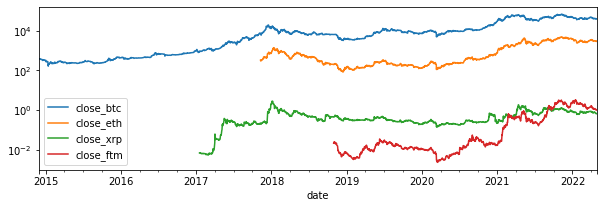

In [7]:
df_merged.sort_values(by='date').plot(x='date', y=['close_btc', 'close_eth', 'close_xrp', 'close_ftm'],
                                      logy=True, figsize=(10,3))


# **Exploratory Data Analysis (EDA)**


In [8]:
df_merged_after_2019 = df_merged.loc[df_merged.date > '2019', :]

assert df_merged_after_2019.isnull().sum().sum() == 0

In [9]:
pd.options.mode.chained_assignment = None
assets =  ['btc', 'eth', 'xrp', 'ftm']

close_values = ['close_' + s for s in assets]
close_returns = [x + '_return' for x in close_values]

for i, x in enumerate(close_values):
  df_merged_after_2019[close_returns[i]] = df_merged_after_2019[x].pct_change(1).copy(deep=True)
  df_merged_after_2019[close_returns[i]].fillna(method="ffill", inplace=True)
  df_merged_after_2019[close_returns[i]].fillna(method="bfill", inplace=True)

(0.0, 10.0)

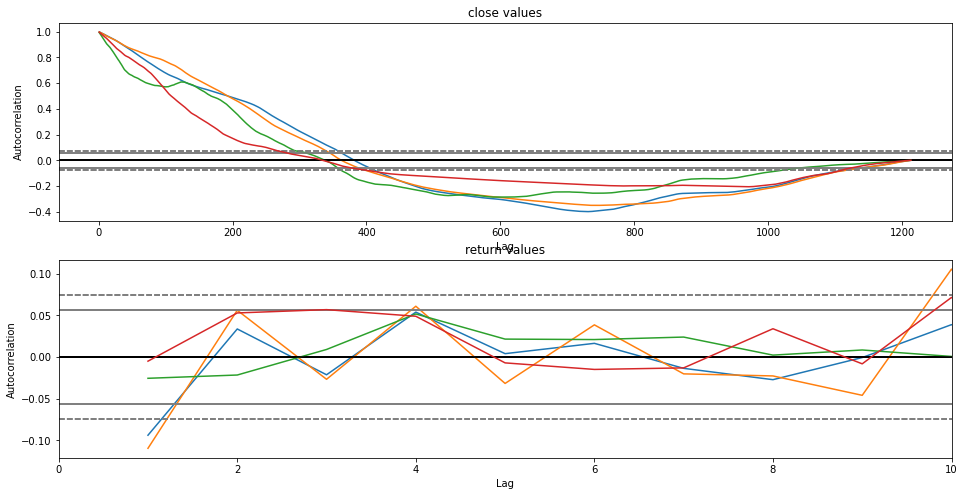

In [10]:
f, axes = plt.subplots(2, figsize=(16,8))

for i, x in enumerate(close_values):
  axes[0] = pd.plotting.autocorrelation_plot(df_merged_after_2019[x], ax=axes[0])

for i, x in enumerate(close_returns):
  axes[1] = pd.plotting.autocorrelation_plot(df_merged_after_2019[x], ax=axes[1])

axes[0].title.set_text('close values')
axes[1].title.set_text('return values')

axes[1].set_xlim([0, 10])

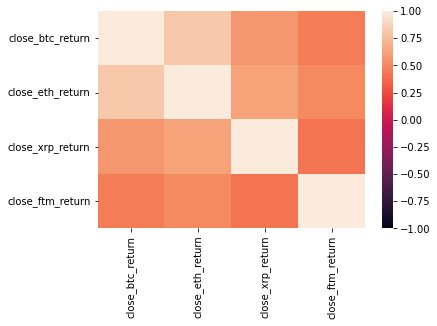

In [11]:
correlation_matrix = df_merged_after_2019[close_returns].corr()

sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns,
        vmin = -1,
        vmax= + 1)